# ========================================
# 1. Introduction & Setup
# ========================================

# This notebook demonstrates an end-to-end workflow: 
# EDA, data cleaning, feature engineering, 
# modeling with XGBoost, hyperparameter tuning using Optuna, 
# and explainability using SHAP.

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error

# XGBoost
from xgboost import XGBRegressor

# For bayesian optimization
import optuna

# For SHAP explanability 
import shap

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100) 
# set_option() is used to configure pandas settings globally
# 'display.max_columns' specifies the maximum number of columns that should be displayed in the output.

# ========================================
# 2. Data Loading
# ========================================

In [2]:
train = pd.read_csv(r'C:\Users\shruti.y.agarwal\Desktop\Practice\ML\Regression with Insurance Data Kaggle\train.csv') 
test = pd.read_csv(r'C:\Users\shruti.y.agarwal\Desktop\Practice\ML\Regression with Insurance Data Kaggle\test.csv') 

# Check the shape
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1200000, 21)
Test shape: (800000, 20)


In [3]:
# Identify target variable and ID column
TARGET = 'Premium Amount'
ID_COL = 'id'

# ========================================
# 3. Initial Exploration and EDA
# ========================================

In [4]:
# Quick look at the data
display(train.head())

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [6]:
display(train.describe(include='all'))
# describe give summary of numerical columns
# describe(include='all') give summary of numerical and categorical columns

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
count,1.200000e+06,1.181295e+06,1200000,1.155051e+06,1181471,1.090328e+06,1200000,841925,1.125924e+06,1200000,1200000,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1200000,1122176,1200000,1200000,1200000,1.200000e+06
unique,NaN,NaN,2,NaN,3,NaN,4,3,NaN,3,3,NaN,NaN,NaN,NaN,167381,3,2,4,3,NaN
top,NaN,NaN,Male,NaN,Single,NaN,Master's,Employed,NaN,Suburban,Premium,NaN,NaN,NaN,NaN,2020-02-08 15:21:39.134960,Average,Yes,Weekly,House,NaN
freq,NaN,NaN,602571,NaN,395391,NaN,303818,282750,NaN,401542,401846,NaN,NaN,NaN,NaN,142,377905,601873,306179,400349,NaN
mean,5.999995e+05,4.114556e+01,NaN,3.274522e+04,NaN,2.009934e+00,NaN,NaN,2.561391e+01,NaN,NaN,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,NaN,NaN,NaN,NaN,NaN,1.102545e+03
std,3.464103e+05,1.353995e+01,NaN,3.217951e+04,NaN,1.417338e+00,NaN,NaN,1.220346e+01,NaN,NaN,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,NaN,NaN,NaN,NaN,NaN,8.649989e+02
min,0.000000e+00,1.800000e+01,NaN,1.000000e+00,NaN,0.000000e+00,NaN,NaN,2.012237e+00,NaN,NaN,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,NaN,NaN,NaN,NaN,NaN,2.000000e+01
25%,2.999998e+05,3.000000e+01,NaN,8.001000e+03,NaN,1.000000e+00,NaN,NaN,1.591896e+01,NaN,NaN,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,NaN,NaN,NaN,NaN,NaN,5.140000e+02
50%,5.999995e+05,4.100000e+01,NaN,2.391100e+04,NaN,2.000000e+00,NaN,NaN,2.457865e+01,NaN,NaN,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,NaN,NaN,NaN,NaN,NaN,8.720000e+02
75%,8.999992e+05,5.300000e+01,NaN,4.463400e+04,NaN,3.000000e+00,NaN,NaN,3.452721e+01,NaN,NaN,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,NaN,NaN,NaN,NaN,NaN,1.509000e+03


In [7]:
# Check data types
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

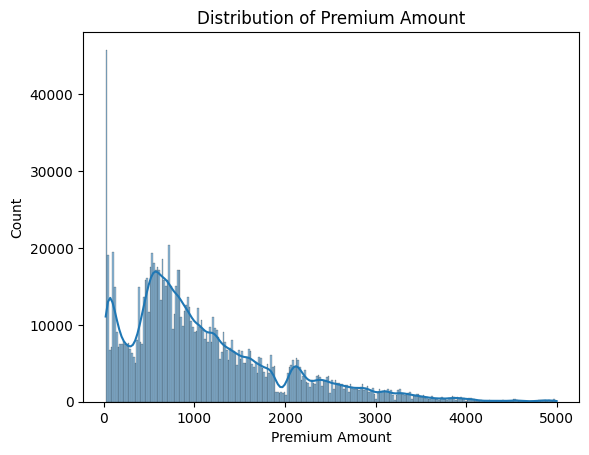

In [8]:
# Distribution of target
sns.histplot(train[TARGET], kde=True) # kde=True adds a smooth curve to the histogram,
plt.title("Distribution of Premium Amount")
plt.show()

In [9]:
# Check missing values
missing_values = train.isnull().sum().sort_values(ascending=False)
print("Missing values in train:\n", missing_values)

Missing values in train:
 Previous Claims         364029
Occupation              358075
Credit Score            137882
Number of Dependents    109672
Customer Feedback        77824
Health Score             74076
Annual Income            44949
Age                      18705
Marital Status           18529
Vehicle Age                  6
Insurance Duration           1
id                           0
Property Type                0
Exercise Frequency           0
Smoking Status               0
Policy Type                  0
Policy Start Date            0
Location                     0
Education Level              0
Gender                       0
Premium Amount               0
dtype: int64


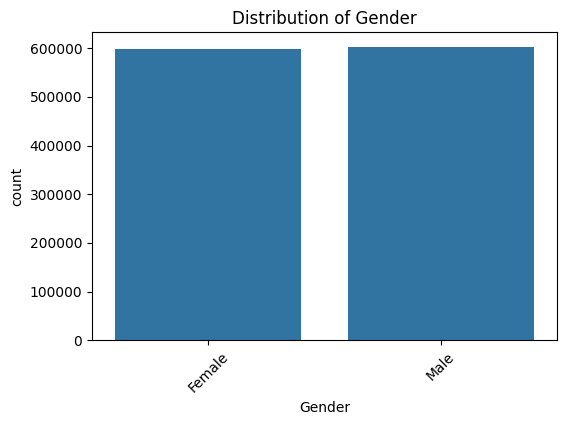

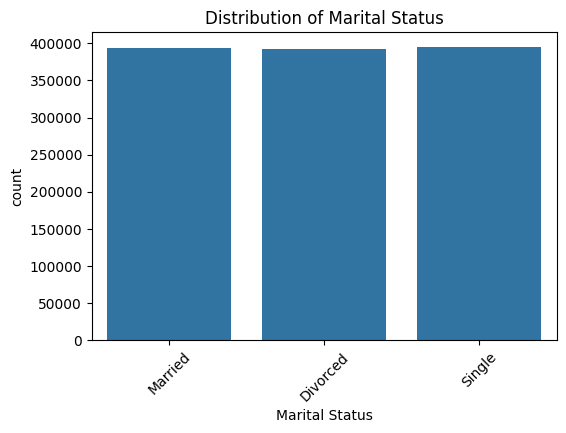

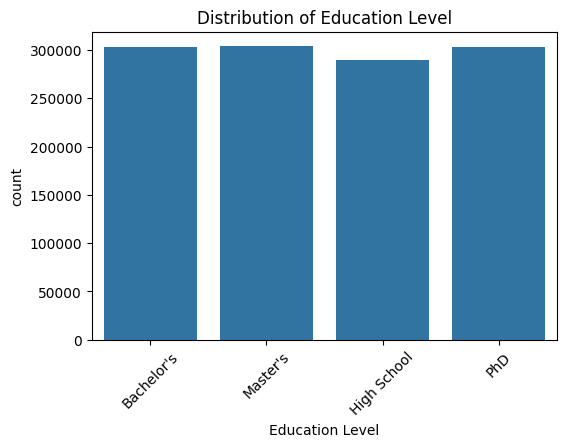

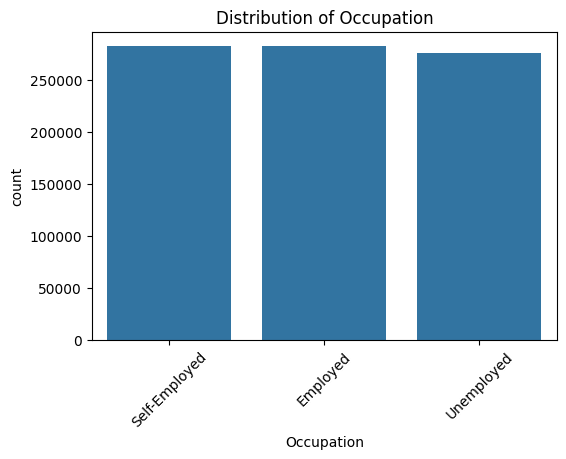

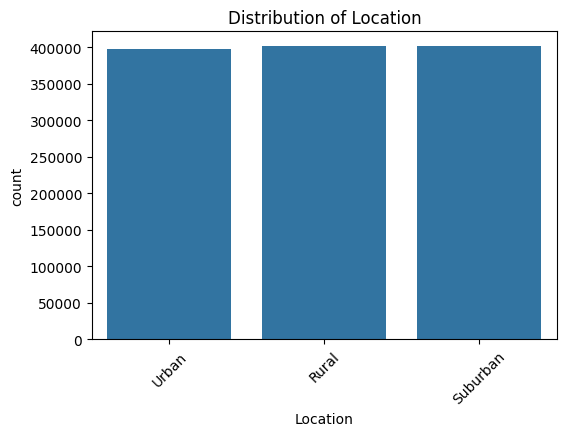

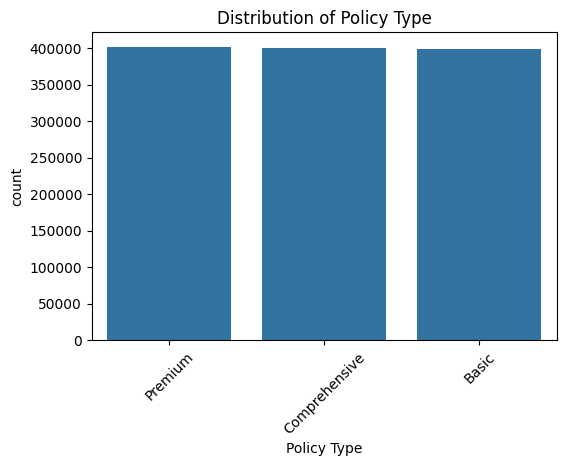

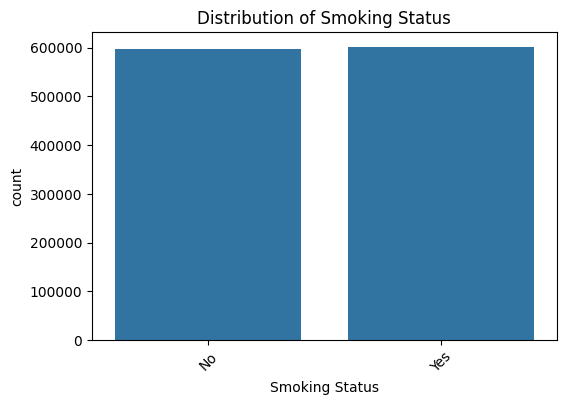

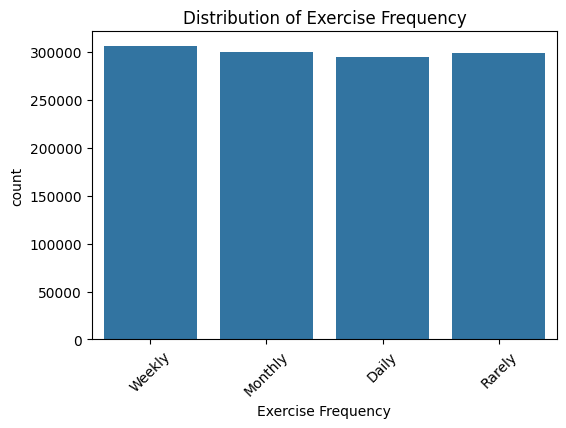

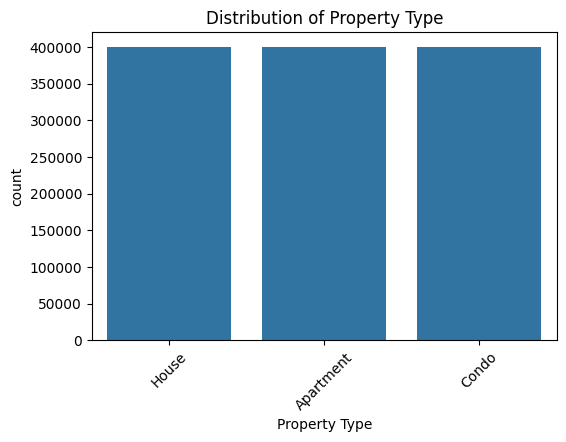

In [10]:
# Categorical Features distribution
cat_features = ['Gender','Marital Status','Education Level','Occupation','Location','Policy Type','Smoking Status','Exercise Frequency','Property Type']

for c in cat_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=c, data=train)
    plt.title(f"Distribution of {c}")
    plt.xticks(rotation=45)
    plt.show()

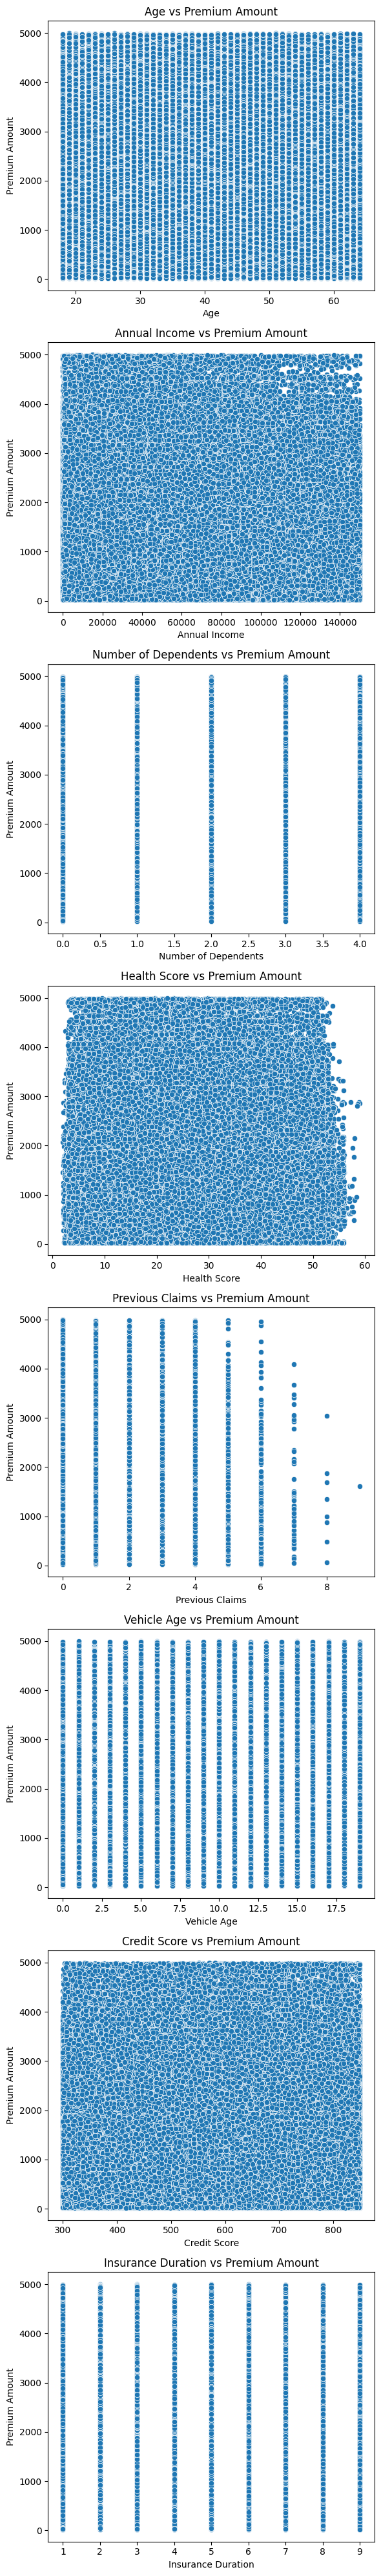

In [11]:
# Relationship between numeric features and target
num_features = ['Age','Annual Income','Number of Dependents','Health Score',
                'Previous Claims','Vehicle Age','Credit Score','Insurance Duration']
fig, axes = plt.subplots(len(num_features), 1, figsize=(6, 40))

for i, col in enumerate(num_features):
    sns.scatterplot(x=train[col], y=train[TARGET], ax=axes[i])
    axes[i].set_title(f"{col} vs {TARGET}")
plt.tight_layout()
plt.show()


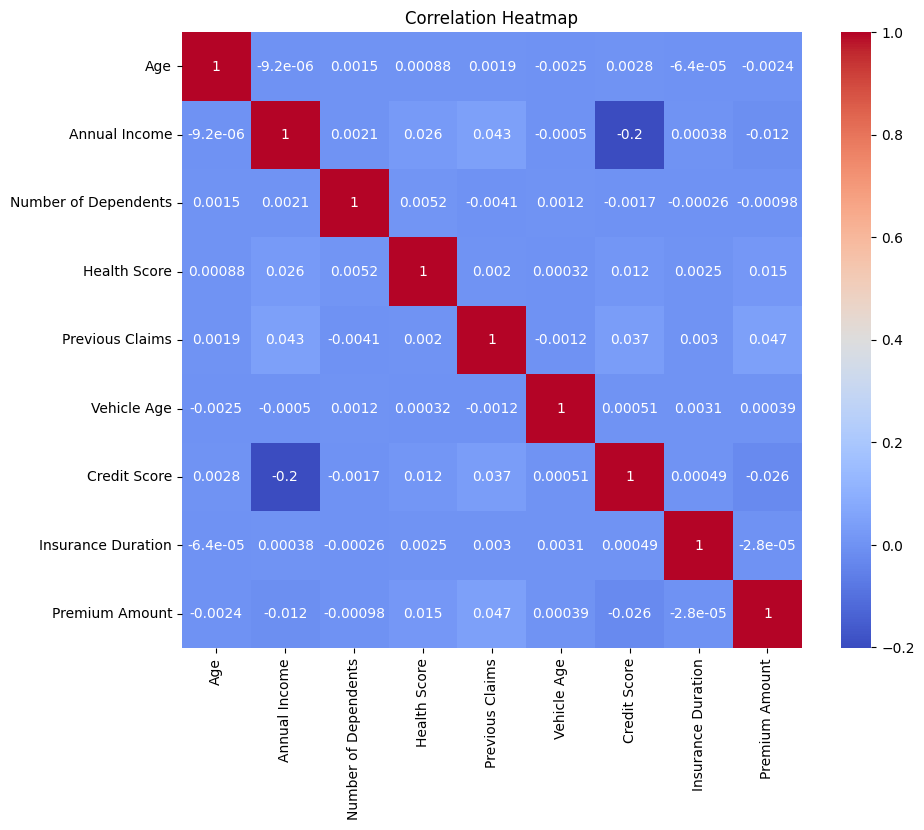

In [12]:
# Check correlation among numerical features
corr = train[num_features+[TARGET]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# ========================================
# 4. Data Cleaning and Preprocessing
# ========================================

In [14]:
# Example of cleaning steps:
# Fix incorrect data types
# Convert Policy Start Date to datetime if present and not in correct format
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'], errors='coerce')
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'], errors='coerce')

In [17]:
columns_with_missing = ['Previous Claims', 'Occupation', 'Credit Score', 
                        'Number of Dependents', 'Customer Feedback',
                        'Health Score', 'Annual Income', 'Age', 
                        'Marital Status', 'Vehicle Age', 'Insurance Duration'
                       ]

for col in columns_with_missing:
    # Create a new binary column indicating missingness
    train[col+'_missing'] = train[col].isnull().astype(int) # create new column having suffix as missing 
    test[col+'_missing'] = test[col].isnull().astype(int) #astype(int) insert 1 for missing values and 0 for non missing values

In [18]:
display(train.head())

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Previous Claims_missing,Occupation_missing,Credit Score_missing,Number of Dependents_missing,Customer Feedback_missing,Health Score_missing,Annual Income_missing,Age_missing,Marital Status_missing,Vehicle Age_missing,Insurance Duration_missing
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0,0,0,0,0,0,0,0,0,0,0,0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0,0,1,0,0,0,0,0,0,0,0,0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0,0,0,1,0,0,0,0,0,0,0,0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0,0,1,0,0,0,0,0,0,0,0,0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0,0,0,0,0,0,0,0,0,0,0,0


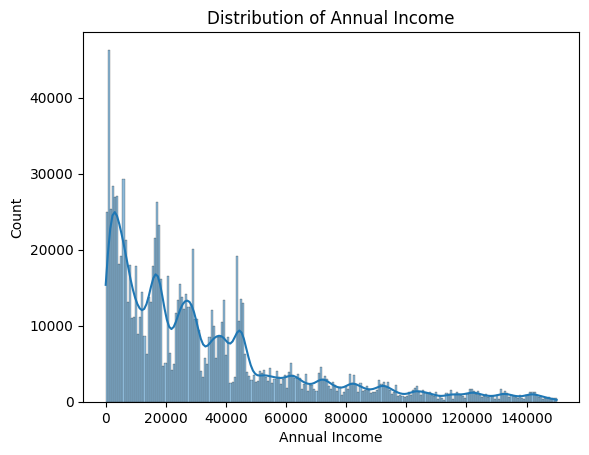

In [19]:
sns.histplot(train['Annual Income'], kde=True)
plt.title('Distribution of Annual Income')
plt.show()
# this shows that annual income is skewed towards lower value

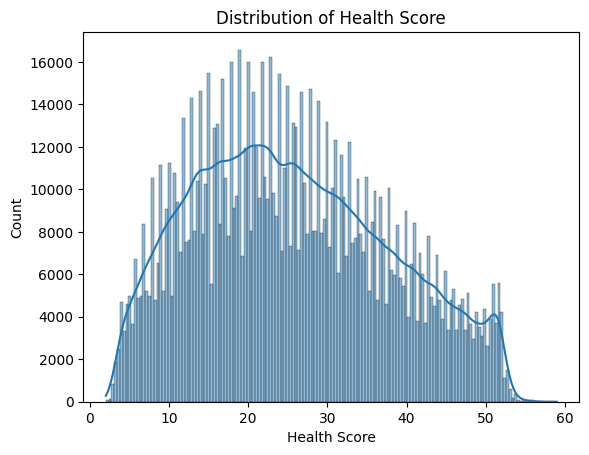

In [20]:
sns.histplot(train['Health Score'], kde=True)
plt.title('Distribution of Health Score')
plt.show()
# this shows that Health Score is little bit skewed towards lower value

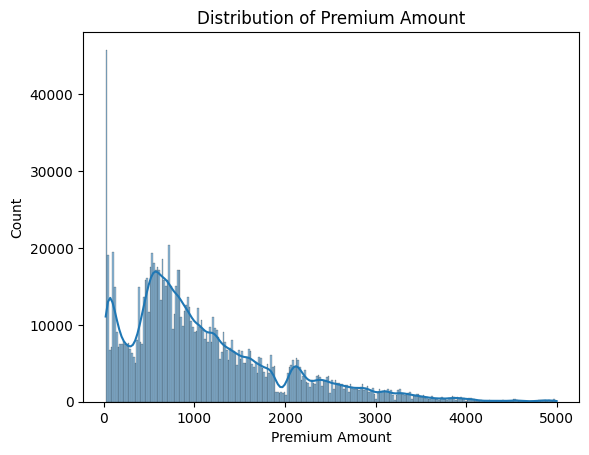

In [21]:
sns.histplot(train['Premium Amount'], kde=True)
plt.title('Distribution of Premium Amount')
plt.show()
# this shows that Premium Amount is skewed towards lower value

In [22]:
# Address skewed features: 'Annual Income', 'Premium Amount', 'Health Score' may be skewed
# Apply log transform to reduce skewness if needed (only to non-negative features)
# We will be careful with transforming the target for RMSLE evaluation.

train['Annual Income'] = np.log1p(train['Annual Income'])
test['Annual Income'] = np.log1p(test['Annual Income'])

train['Health Score'] = np.log1p(train['Health Score'])
test['Health Score'] = np.log1p(test['Health Score'])

# Consider transforming the target:
# RMSLE is usually applied to positive targets. We can still predict on normal scale, 
# but optimizing a model on a log-transformed target often helps.
train[TARGET] = np.log1p(train[TARGET])  # log-transform the target for modeling

# Distribution after log tranformation

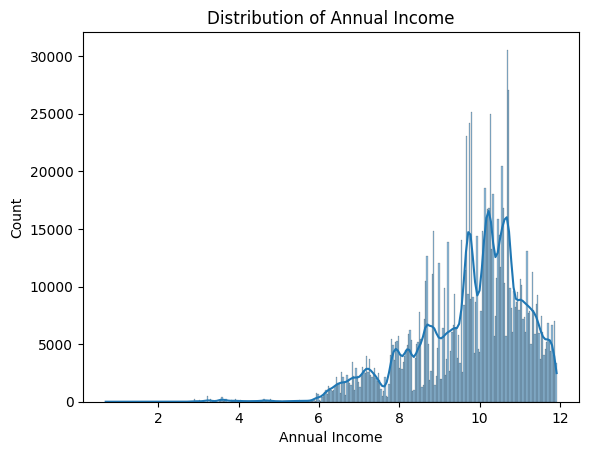

In [24]:
sns.histplot(train['Annual Income'], kde=True)
plt.title('Distribution of Annual Income')
plt.show()

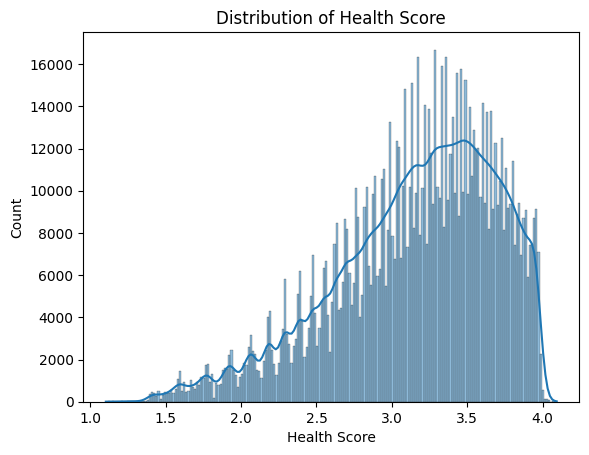

In [25]:
sns.histplot(train['Health Score'], kde=True)
plt.title('Distribution of Health Score')
plt.show()

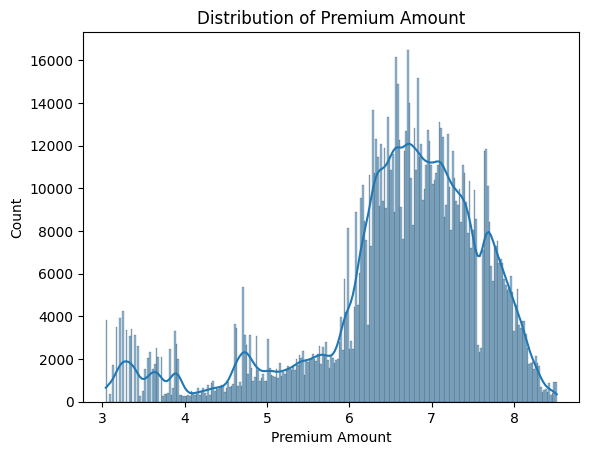

In [26]:
sns.histplot(train['Premium Amount'], kde=True)
plt.title('Distribution of Premium Amount')
plt.show()

# ========================================
# 5. Feature Engineering
# ========================================

In [27]:
# Example feature engineering:
# - Extract date features from 'Policy Start Date'
train['Policy_Year'] = train['Policy Start Date'].dt.year
train['Policy_Month'] = train['Policy Start Date'].dt.month
train['Policy_Day'] = train['Policy Start Date'].dt.day

test['Policy_Year'] = test['Policy Start Date'].dt.year
test['Policy_Month'] = test['Policy Start Date'].dt.month
test['Policy_Day'] = test['Policy Start Date'].dt.day

# Drop original date column if it's no longer needed
train.drop(['Policy Start Date'], axis=1, inplace=True)
test.drop(['Policy Start Date'], axis=1, inplace=True)

In [28]:
# Text feature: 'Customer Feedback'
# For example, we could do a length count or number of words as a simple feature
train['Feedback_Length'] = train['Customer Feedback'].astype(str).apply(lambda x: len(x))
test['Feedback_Length'] = test['Customer Feedback'].astype(str).apply(lambda x: len(x))

train['Feedback_WordCount'] = train['Customer Feedback'].astype(str).apply(lambda x: len(x.split()))
test['Feedback_WordCount'] = test['Customer Feedback'].astype(str).apply(lambda x: len(x.split()))

# Drop the raw text if we prefer not to use it directly
train.drop(['Customer Feedback'], axis=1, inplace=True)
test.drop(['Customer Feedback'], axis=1, inplace=True)

In [29]:
# For categorical variables, we will use one-hot or label encoding
# Let's use one-hot encoding for simplicity
all_data = pd.concat([train, test], sort=False)
all_data = pd.get_dummies(all_data, columns=cat_features, drop_first=True)

# drop_first=True is used to drop the first category of each categorical variable when creating dummy/one-hot encoded variables.
# This helps to avoid multicollinearity in models, particularly in linear regression.

# Now split back into train and test
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [32]:
# Make sure target is still in train
# We moved our target earlier, so it's safe. Just reconfirm structure
y = train[TARGET]
X = train.drop([TARGET, ID_COL], axis=1)
X_test = test.drop([TARGET, ID_COL], axis=1, errors='ignore') # test doesn't have target

print("Final training shape:", X.shape)
print("Final test shape:", X_test.shape)

Final training shape: (1200000, 42)
Final test shape: (800000, 42)


# ========================================
# 6. Train-Validation Split (Local)
# ========================================

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================================
# 7. Baseline Modeling with XGBoost
# ========================================

In [34]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred)) # mean_squared_log_error focus on relative error rather than absolute difference

# Preliminary model
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

y_pred_val = xgb_reg.predict(X_val)
val_score = rmsle(np.expm1(y_val), np.expm1(y_pred_val))  # transform back the exponent
print("Baseline RMSLE on validation:", val_score)

Baseline RMSLE on validation: 1.0480830224264468


# ========================================
# 8. Bayesian Optimization with Optuna
# ========================================

In [ ]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'auto',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10)
    }
    # Using K-Fold for evaluation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    rmsle_scores = []
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]
        
        model = XGBRegressor(**param)
        model.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], verbose=False)
        preds = model.predict(X_vl)
        fold_score = rmsle(np.expm1(y_vl), np.expm1(preds))
        rmsle_scores.append(fold_score)
    
    return np.mean(rmsle_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best RMSLE:", study.best_value)
print("Best parameters:", study.best_params)

Optuna is an open-source, automatic hyperparameter optimization framework designed to efficiently optimize machine learning models or any user-defined functions. It uses state-of-the-art optimization techniques to search for the best hyperparameter values, making it an effective tool for both beginners and experts in machine learning.

Key Features of Optuna
Automatic Hyperparameter Search:

Automatically selects hyperparameters using advanced techniques like Tree-structured Parzen Estimator (TPE) or grid/random search.
Dynamic Search Spaces:

Allows you to define hyperparameter search spaces programmatically, which can adapt based on trial outcomes.
Lightweight and Scalable:

Can be integrated into any Python script or Jupyter Notebook without heavy dependencies.
Efficient Pruning:

Stops unpromising trials early, saving computational resources.
Visualization:

Provides tools to visualize search results and hyperparameter importance.

In [ ]:
# Train final model with best params
best_params = study.best_params
final_model = XGBRegressor(**best_params, random_state=42)
final_model.fit(X, y)

# ========================================
# 9. Model Evaluation using RMSLE on Validation
# ========================================

In [ ]:
# If we have a separate test set (we do - but no target), we will just generate predictions:
# We'll trust cross-validation results. For final submission on Kaggle:
y_pred_test = final_model.predict(X_test)
# Remember to invert the log transform for predictions
y_pred_test = np.expm1(y_pred_test)

In [ ]:
# Save predictions
submission = pd.DataFrame({ID_COL: test[ID_COL], TARGET: y_pred_test})
# submission.to_csv("submission.csv", index=False)

In [ ]:
# ========================================
# 10. Explainability with SHAP
# ========================================
# Use a subset of data to speed up SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X.sample(1000, random_state=42))

In [ ]:
# Global Feature Importance
shap.summary_plot(shap_values, X.sample(1000, random_state=42), plot_type='bar')

In [ ]:
# Detailed SHAP summary plot
shap.summary_plot(shap_values, X.sample(1000, random_state=42))

In [ ]:
# Local explanation for a single instance
instance_idx = 10

shap.force_plot(explainer.expected_value, shap_values[instance_idx,:], 
                X.iloc[instance_idx,:])

SHAP (SHapley Additive exPlanations) is a popular library in Python for explaining the predictions of machine learning models. It is based on the concept of Shapley values from cooperative game theory, which provide a fair way to attribute the contribution of each feature to a prediction. SHAP provides insights into why a model made a particular prediction and how much each feature contributed to it.

Key Features of SHAP
Feature Importance:

SHAP can calculate global feature importance, showing how significant each feature is across the entire dataset.
Explain Individual Predictions:

SHAP provides explanations for individual predictions, showing how each feature influenced the outcome.
Model-Agnostic:

SHAP works with any machine learning model, including tree-based models (XGBoost, LightGBM), linear models, and neural networks.
Visualizations:

SHAP offers powerful visualization tools, such as:
Force plots: Show how feature contributions add up to a prediction.
Summary plots: Provide an overview of feature impacts across the dataset.
Dependence plots: Illustrate the relationship between a feature and the prediction.
example:
###### Train a model
model = xgb.XGBRegressor().fit(X_train, y_train)

###### Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

###### Explain predictions for the test set
shap_values = explainer(X_test)

###### Visualization: Summary plot
shap.summary_plot(shap_values, X_test)

###### Visualization: Force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# ========================================
# 11. Conclusion
# ========================================

# - We performed extensive EDA, cleaning, and feature engineering.
# - We log-transformed skewed features and target to handle skewness.
# - We used Bayesian optimization to fine-tune XGBoost parameters.
# - We evaluated the model using RMSLE.
# - We used SHAP to gain insights into feature importance both globally and locally.

# The final submission.csv file contains our predictions on the test dataset.